In [2]:
%matplotlib inline
import os
import sys
import pylab as plt
import numpy as np
from glob import glob
import fitsio
from collections import Counter

In [3]:
from astrometry.util.fits import *
from astrometry.util.util import *
from astrometry.libkd.spherematch import match_radec
from tractor import *
from astrometry.util.starutil_numpy import *

In [4]:
sys.path.insert(0, '/global/u1/d/dstn/legacypipe/py')

In [5]:
from legacypipe.format_catalog import get_units_for_columns

In [6]:
G = fits_table('/global/cscratch1/sd/dstn/gaia-mask-dr10.fits')

In [7]:
Counter(G.isgalaxy)

Counter({0: 36143736})

In [8]:
G.delete_column('isgalaxy')

In [9]:
np.sum(G.jmag != 0), np.sum(G.hmag != 0), np.sum(G.kmag != 0)

(9658, 9658, 9658)

In [10]:
G.delete_column('jmag')
G.delete_column('hmag')
G.delete_column('kmag')

In [11]:
np.nanmin(G.zguess), np.nanmax(G.zguess)

(-1.3516648, 21.548058)

In [12]:
np.sum(np.isfinite(G.zguess))

36142135

In [13]:
Counter(G.ref_cat)

Counter({'GE': 36134078, 'T2': 9658})

In [ ]:
#plt.plot(G.mag, G.mask_mag, 'b.');

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [14]:
Counter(G.istycho)

Counter({False: 34503478, True: 1640258})

In [15]:
Counter(G.ismedium)

Counter({True: 36143439, False: 297})

In [16]:
Counter(G.isbright)

Counter({True: 4229463, False: 31914273})

In [17]:
Counter(G.donotfit)

Counter({False: 36142276, True: 1460})

In [18]:
Counter(G.source_id == G.ref_id)

Counter({True: 36134078, False: 9658})

In [19]:
Counter(G.istycho * np.logical_not(G.isgaia))

Counter({False: 36134078, True: 9658})

In [20]:
G.delete_column('source_id')

In [21]:
Counter(G.duplicated_source)

Counter({False: 36143736})

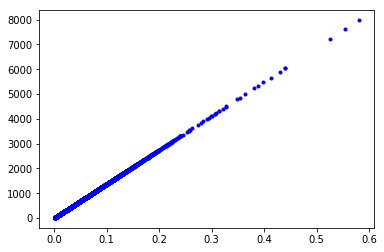

In [22]:
plt.plot(G.radius, G.radius_pix, 'b.');

In [22]:
Counter(G.in_bounds)

Counter({True: 36143736})

In [23]:
Counter(G.islargegalaxy)

Counter({False: 36143736})

In [25]:
Counter(G.iscluster)

Counter({False: 33941026})

In [26]:
Counter(G.freezeparams)

Counter({False: 33941026})

In [27]:
Counter(G.pa == 0.)

Counter({True: 33941026})

In [28]:
Counter(G.ba == 0.)

Counter({True: 33941026})

In [24]:
for c in ['in_bounds', 'islargegalaxy', 'iscluster', 'freezeparams', 'pa', 'ba']:
    G.delete_column(c)

In [25]:
G.delete_column('keep_radius')

In [36]:
G.about()

tabledata object with 36143736 rows and 48 columns:
   brickname (<class 'numpy.ndarray'>) shape (36143736,) dtype <U8
   dec (<class 'numpy.ndarray'>) shape (36143736,) dtype >f8
   dec_ivar (<class 'numpy.ndarray'>) shape (36143736,) dtype >f4
   decam_mag_g (<class 'numpy.ndarray'>) shape (36143736,) dtype >f4
   decam_mag_i (<class 'numpy.ndarray'>) shape (36143736,) dtype >f4
   decam_mag_r (<class 'numpy.ndarray'>) shape (36143736,) dtype >f4
   decam_mag_z (<class 'numpy.ndarray'>) shape (36143736,) dtype >f4
   donotfit (<class 'numpy.ndarray'>) shape (36143736,) dtype bool
   gaia_astrometric_excess_noise (<class 'numpy.ndarray'>) shape (36143736,) dtype >f4
   gaia_astrometric_excess_noise_sig (<class 'numpy.ndarray'>) shape (36143736,) dtype >f4
   gaia_astrometric_params_solved (<class 'numpy.ndarray'>) shape (36143736,) dtype uint8
   gaia_astrometric_sigma5d_max (<class 'numpy.ndarray'>) shape (36143736,) dtype >f4
   gaia_duplicated_source (<class 'numpy.ndarray'>) shape

In [37]:
gaiacols = ['phot_g_mean_mag', 'phot_g_mean_flux_over_error', 'phot_g_n_obs', 'phot_bp_mean_mag', 'phot_bp_mean_flux_over_error',
          #'phot_bp_n_obs',
            'phot_rp_mean_mag', 'phot_rp_mean_flux_over_error',
            #'phot_rp_n_obs',
            #'phot_variable_flag',
          'astrometric_excess_noise', 'astrometric_excess_noise_sig',
            #'astrometric_n_obs_al', 'astrometric_n_good_obs_al',
          #'astrometric_weight_al',
            'duplicated_source',
            #'a_g_val', 'e_bp_min_rp_val',
            'phot_bp_rp_excess_factor',
          'astrometric_sigma5d_max', 'astrometric_params_solved',
           'ipd_frac_multi_peak', 'ipd_gof_harmonic_amplitude', 'ruwe']
for c in gaiacols:
    # HACK
    if 'gaia_'+c in G.get_columns():
        print('skip', c)
        continue
    G.rename(c, 'gaia_'+c)

skip phot_g_mean_mag
skip phot_g_mean_flux_over_error
skip phot_g_n_obs
skip phot_bp_mean_mag
skip phot_bp_mean_flux_over_error
skip phot_rp_mean_mag
skip phot_rp_mean_flux_over_error
skip astrometric_excess_noise
skip astrometric_excess_noise_sig
skip duplicated_source
skip phot_bp_rp_excess_factor
skip astrometric_sigma5d_max
skip astrometric_params_solved


In [ ]:
# Column ordering
cols = ('ra dec ref_cat ref_id ref_epoch mag mask_mag radius radius_pix '
        + 'pmra pmdec parallax ra_ivar dec_ivar pmra_ivar pmdec_ivar parallax_ivar '
        + 'istycho isgaia isbright ismedium pointsource donotfit '
        + 'decam_mag_g decam_mag_r decam_mag_i decam_mag_z zguess '
        + 'brickname ibx iby').split()
cols += ['gaia_'+c for c in gaiacols]

In [ ]:
units = get_units_for_columns(cols, '', extras=dict(radius='deg'))

In [34]:
#G.writeto('/global/cscratch1/sd/dstn/gaia-mask-dr9-fixed.fits', columns=cols, units=units)

In [50]:
from astrometry.util.plotutils import loghist,plothist

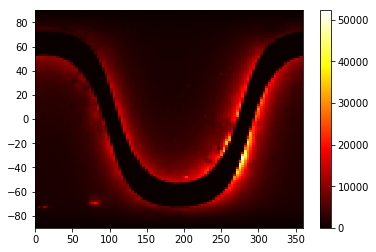

In [51]:
plothist(G.ra, G.dec);

In [52]:
len(G)

36143736

In [41]:
home = os.environ['HOME']+'/'
sys.path.append(home + 'desimodel/py')
sys.path.append(home + 'desiutil/py')

In [46]:
os.environ['DESIMODEL'] = home + 'desimodel-data-0.17.0'

In [47]:
from desimodel.footprint import is_point_in_desi
from desimodel.io import load_tiles

In [48]:
desitiles = load_tiles()

In [54]:
# Shortcut: assume in_desi is only above Dec=-30
G.in_desi = np.zeros(len(G), bool)
Icheck = np.flatnonzero(G.dec > -30)
G.in_desi[Icheck] = is_point_in_desi(desitiles, G.ra[Icheck], G.dec[Icheck])

In [55]:
#G.in_desi = is_point_in_desi(desitiles, G.ra, G.dec)

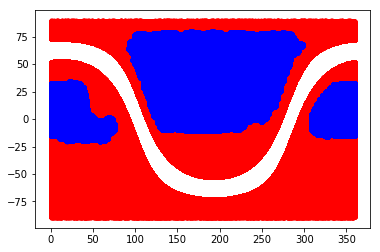

In [56]:
plt.plot(G.ra, G.dec, 'r.')
plt.plot(G.ra[G.in_desi], G.dec[G.in_desi], 'b.');

In [57]:
cols = ('ra dec ref_cat ref_id ref_epoch mag mask_mag radius radius_pix '
        + 'pmra pmdec parallax ra_ivar dec_ivar pmra_ivar pmdec_ivar parallax_ivar '
        + 'in_desi '
        + 'istycho isgaia isbright ismedium pointsource donotfit '
        + 'decam_mag_g decam_mag_r decam_mag_i decam_mag_z zguess '
        + 'brickname ibx iby').split()
cols += ['gaia_'+c for c in gaiacols]
units = get_units_for_columns(cols, '', extras=dict(radius='deg'))
G.writeto('/global/cscratch1/sd/dstn/gaia-mask-dr10-fixed.fits', columns=cols, units=units)

In [58]:
G9 = fits_table('/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/masking/gaia-mask-dr9.fits.gz')

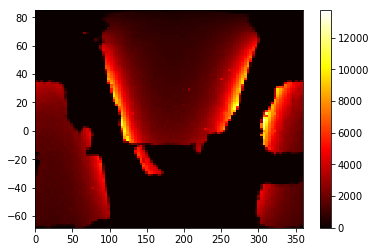

In [59]:
plothist(G9.ra, G9.dec);

In [60]:
len(G9), len(G)

(12701109, 36143736)